# Convolutional Neural Networks


## Introduction
In this practical we will cover the basics of convolutional neural networks, or "ConvNets". ConvNets were invented in the late 1980s/early 1990s, and have had tremendous success especially with vision (although they have also been used very successfully in speech processing pipelines, and more recently, for machine translation).

## Learning Objectives
* Be able to explain what a convolutional layer does and how it's different from a fully-connected layer 
* Understand  the assumptions and trade-offs that are being made when using convolutional architectures
* Be able to build a convolutional architecture using Tensorflow and Keras Layers
* Be able to use Keras to train a model on a dataset
* Implement either batch normalisation or a very small residual network

## Running on GPU
For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelelator" box. This is all you need to do, Colab and Tensorflow will take care of the rest! 

In [23]:
#@title Imports (RUN ME!) { display-mode: "form" }

# TODO: Swallow output
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

# from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running in Eager mode')

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-12.0.1.jdk/Contents/Home/bin/apt" (-1)
Running in Eager mode.


### Convolutional Layers

A convolutional layer maps an input *volume* (meaning, a 3-D input tensor, e.g. [width, height, channels]) to an output volume through a set of learnable filters, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute element-wise dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have such a set of filters, and each of them will produce a separate 2-dimensional activation map. We then stack these activation maps along the depth-dimension to produce the output volume.

By using these filters which map to a small sub-volume of the input, we can to a large extent,control the parameter explosion that we would get with a (fully-connected) feed-forward network. This **parameter sharing** actually also tends to improve the performance of the model on inputs like natural images because it provides the model with some limited **translation invariance**. Translation invariance means that if the image (or a feature in the image) is translated (moved), the model will not be significantly affected. Think about why this is the case!

The following animation illustrates these ideas, make sure you understand them!

![Convolution Animation](https://miro.medium.com/max/588/1*BMngs93_rm2_BpJFH2mS0Q.gif)

The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer
* **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.

Lets look at a very simple, dummy example to see how the values of the hyper-parameters affect the output size of a convolutional layer.

Input shape: (10, 10, 3)


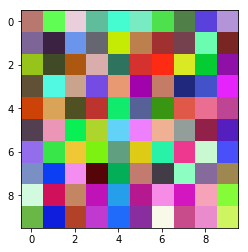

In [52]:
# Create a random colour "image" of shape 10x10 with a depth of 3 (for red, green and blue)
dummy_input = np.random.uniform(size=[10, 10, 3])
fig, ax = plt.subplots(1, 1)
plt.imshow(dummy_input)
ax.grid(False)
print('Input shape: {}'.format(dummy_input.shape))

Now adjust the hyperparameters using the sliders on the right and see how the output shape changes for a [10, 10, 3] input.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The output dimension is:


[9, 9, 3]

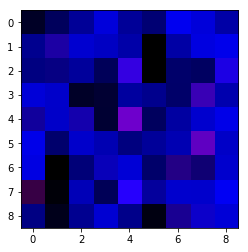

In [26]:
#@title Convolutional layer parameters {run: "auto"}
filters = 3  #@param { type: "slider", min:0, max: 10, step: 1 }
kernel_size = 2 #@param { type: "slider", min:1, max: 10, step: 1 }
stride = 1 #@param { type: "slider", min:1, max: 3, step: 1 }

conv_layer = tf.keras.layers.Conv2D(
    filters=filters, 
    kernel_size=kernel_size, 
    strides=stride,
    padding="valid",
    input_shape=[10, 10, 3])

# Convert the image to a tensor and add an extra batch dimension which
# the convolutional layer expects.
input_tensor = tf.convert_to_tensor(dummy_input[None, :, :, :])
convoluted = conv_layer(input_tensor)

fig, ax = plt.subplots(1, 1)
plt.imshow(np.squeeze(convoluted.numpy()))
ax.grid(False)
print('The output dimension is:')
list([d.value for d in convoluted.shape])[1:]


Note especially how output width and height are related to ```kernel_size``` and ```stride```, and how the output depth is related to ```filters```.

## The CIFAR10 Dataset
Now that we understand convolutional, max-pooling and feed-forward layers, we can combine these as building block to build a ConvNet classifier for images. For this practical, we will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. As we did in Practical 1, we take 10,000 images from the training set to form a validation set and visualise some example images.

In [14]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [15]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

What are the shapes and data-types of train_images and train_labels?

In [16]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


### Visualise examples from the dataset
Run the cell below multiple times to see various images. (They might look a bit blurry because we've blown up the small images.)

/Users/luyolomagangane/Virtual-Environments/venv_deep_learning_p3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


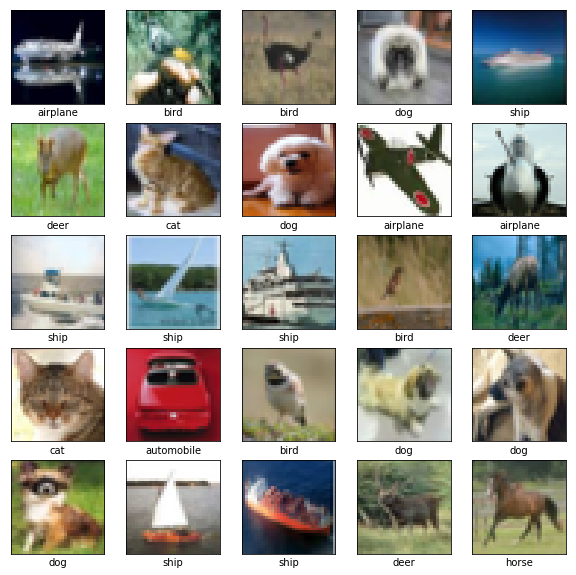

In [17]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

## A ConvNet Classifier
Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers have on the number of parameters, we'll build the model in two stages. 

First, the convolutional layers + max-pooling:

In [18]:
# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])


How many parameters are there in the convolutional part of the architecture? We can easily inspect this using the model summary function in Keras:

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularization technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012.

In [21]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

###Visualizing the model

Let's build a flow-diagram of the model we've constructed to see how information flows between the different layers.

### Training and Validating the model
In the last practical we wrote out the dataset pipeline, loss function and training-loop to give you a good appreciation for how it works. This time, we use the training loop built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets! 

In [25]:
batch_size = 128
num_epochs = 10  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 65s 2ms/sample - loss: 2.3041 - acc: 0.1018 - val_loss: 2.3029 - val_acc: 0.0952
Epoch 2/10
 5632/40000 [===>..........................] - ETA: 53s - loss: 2.3034 - acc: 0.0998

KeyboardInterrupt: 

### Test performance
Finally, we evaluate how well the model does on the held-out test-set

In [27]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 5s 503us/sample - loss: 2.3027 - acc: 0.1000
Final TEST performance
loss: 2.302699471282959
acc: 0.10000000149011612


Note that we achieved roughly 80% training set accuracy, but our test accuracy is only around 67%. What do you think may be the reason for this?

### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [28]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

/Users/luyolomagangane/Virtual-Environments/venv_deep_learning_p3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


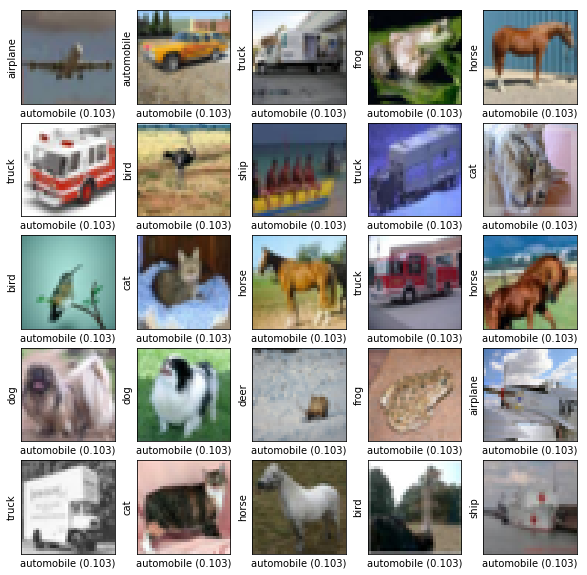

In [30]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))
  

### Question
What do you think of the model's predictions? Looking at the model's confidence (the probability assigned to the predicted class), look for examples of the following cases:
1. The model was correct with high confidence
2. The model was correct with low confidence
3. The model was incorrect with high confidence
4. The model was incorrect with low confidence

What do you think the (relative) loss values would be in those cases? 


## Your Tasks
1. [**ALL**] Experiment with the network architecture, try changing the numbers, types and sizes of layers, the sizes of filters, using different padding etc. How do these decisions affect the performance of the model? In particular, try building a *fully convolutinoal* network, with no (max-)pooling layers. 
2. [**ALL**] Implement BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [research paper](http://proceedings.mlr.press/v37/ioffe15.pdf)) to improve the model's generalisation.
3. [**ADVANCED**] Read about Residual networks ([original paper](https://arxiv.org/pdf/1512.03385.pdf), ) and add **shortcut connections** to the model architecture. Try to build a simple reusable "residual block" as a [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model). 
4. [**OPTIONAL**]. Visualise the filters of the convolutional layers using Matplotlib. **HINT**: You can retrieve a reference to an indivual layer from the sequential Keras model by calling```model.get_layer(name)```, replacing "name" with the name of the layer. 

##Additional Resources

Here's some more information on ConvNets:

* Chris Colah's blog post on [Understanding Convolutions](https://colah.github.io/posts/2014-07-Understanding-Convolutions/)
* [How do convolutional neural networks work?](http://brohrer.github.io/how_convolutional_neural_networks_work.html)
* The [CS231n course](https://cs231n.github.io/)
* [Building blocks of interpretability](https://distill.pub/2018/building-blocks/)

